In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import ParameterGrid
from sklearn import feature_selection
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances_argmin

from rdkit import Chem
from rdkit.Chem import QED
from rdkit.Chem import PandasTools

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

from collections import defaultdict
from scipy.spatial.distance import cdist

from dili_predictor.feature_extractor import load_object, Data, MolecularData
from dili_predictor.ML_plot import MLPlot
from dili_predictor.supervised import *

# Feature extraction for 8 properties

## Calculated the qed properties

In [2]:
df = pd.read_excel('data/reference_database.xlsx')
md = MolecularData()
md.load_data(df=df, smiles_col='SMILES')

Number of data set: 2384


In [3]:
df['properties'] = df['rdmol'].apply(QED.properties)
df['properties'] = df['properties'].apply(lambda x: str(list(x))[1:-1])
features = df['properties'].str.split(',', expand=True)
features = features.astype(np.float)

In [4]:
mask = [True if i=='Pos' else False for i in df.Label]
pos_features = features.loc[mask]
mask = [False if i=='Pos' else True for i in df.Label]
neg_features = features.loc[mask]

In [5]:
pm_df = pd.read_excel('data/Polygonum_database.xlsx')
md = MolecularData()
md.load_data(df=pm_df, smiles_col='SMILES')

Number of data set: 197


In [6]:
pm_df['properties'] = pm_df['rdmol'].apply(QED.properties)
pm_df['properties'] = pm_df['properties'].apply(lambda x: str(list(x))[1:-1])
pm_features = pm_df['properties'].str.split(',', expand=True)
pm_features = pm_features.astype(np.float)

## PCA 2D

explained variance: [3.95686325 1.46127804]
explained variance ratio: [0.49441627 0.18258898]
explained variance ratio (sum): 0.6770052553083582


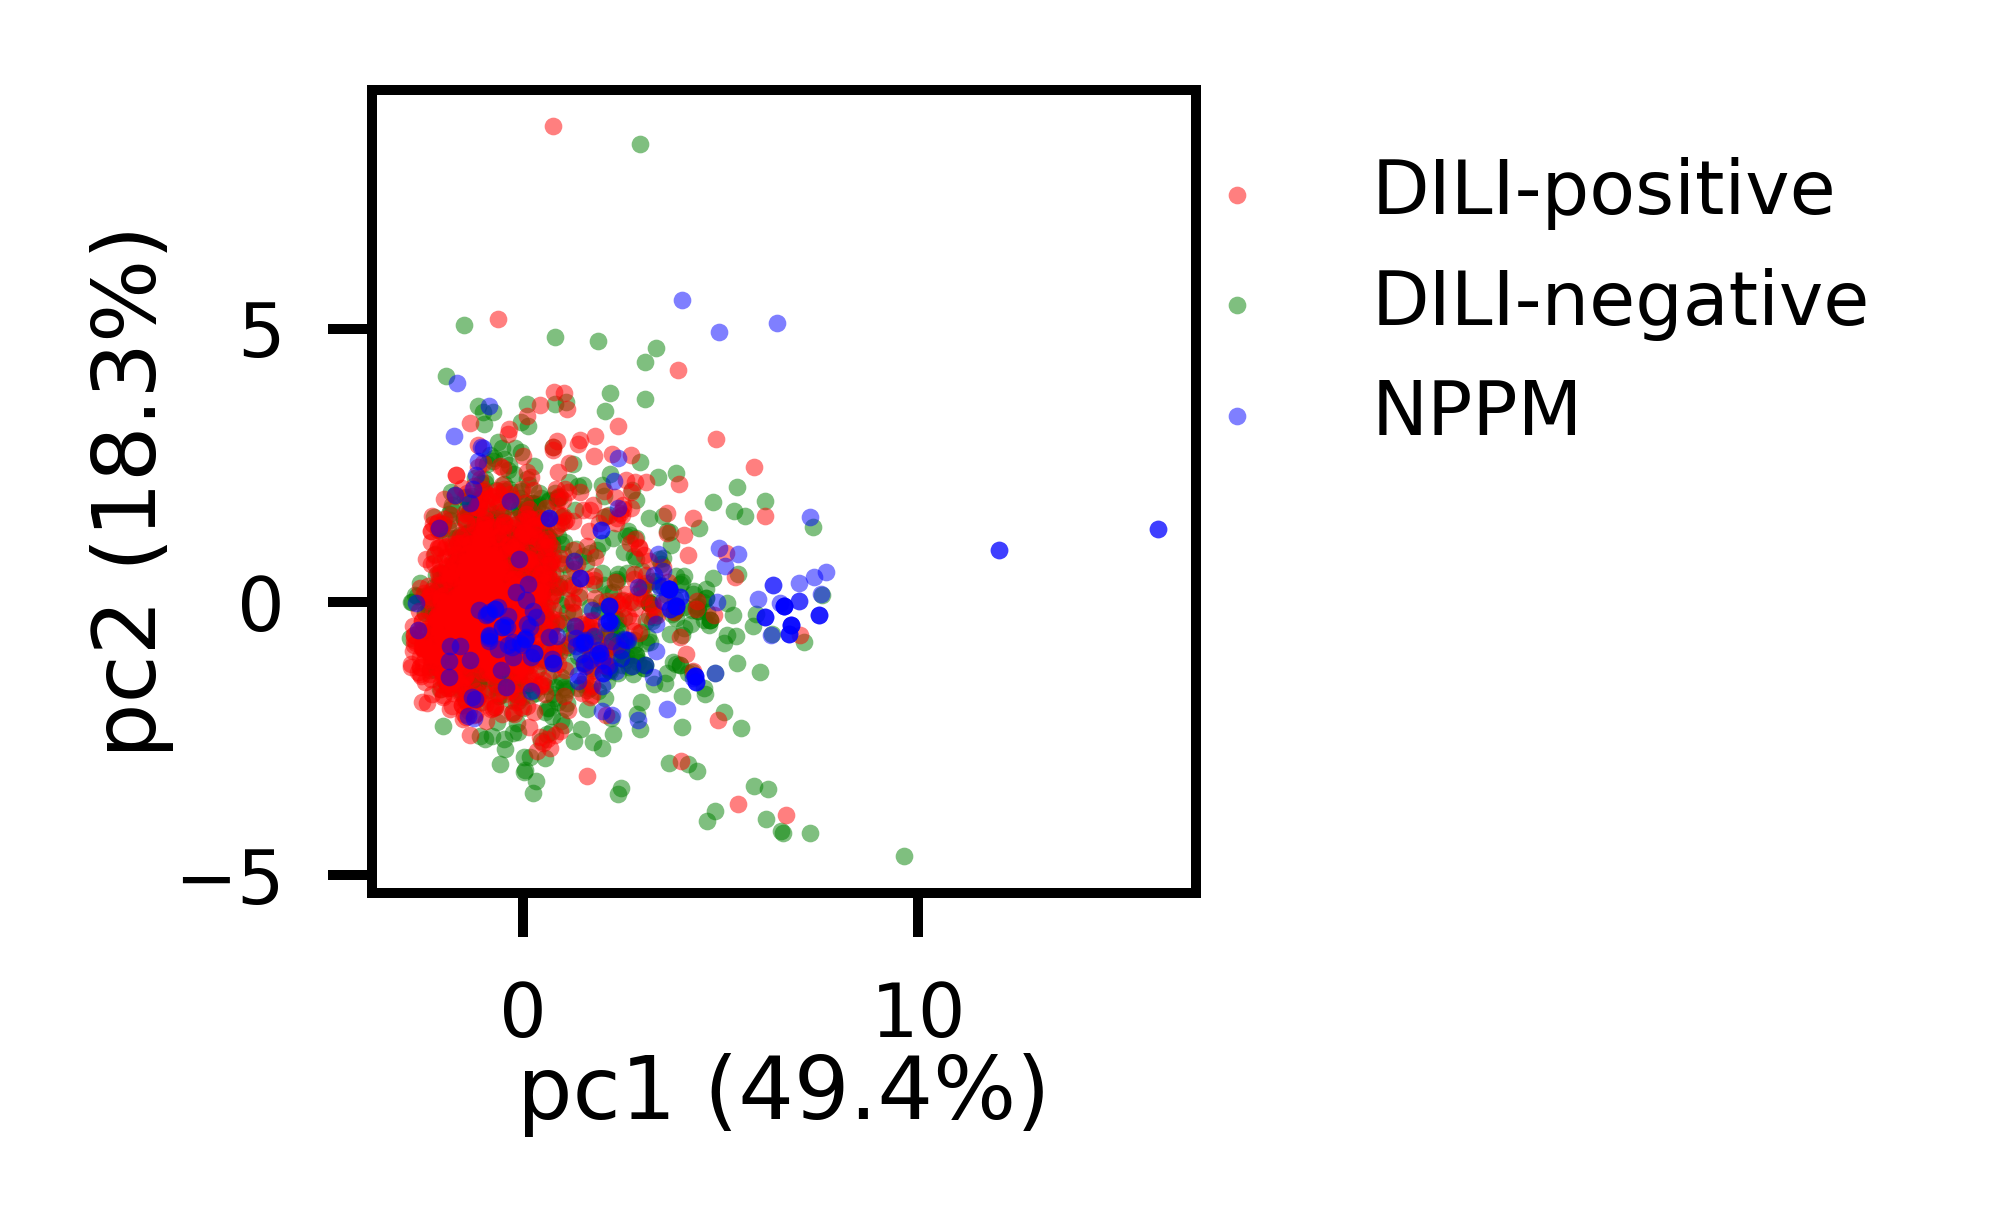

In [7]:
plot = MLPlot()
plot.plot_pca_for3(pos_features, neg_features, pm_features, scale='StandardScaler', component=2, figsize=None, elev=25, azim=165, project=False,
                      alpha=0.5, save_path='results/figure1A.png',
                      label1='DILI-positive', label2='DILI-negative', label3='NPPM',
                      c1='red', c2='green', c3='blue',
                      zorder1=2, zorder2=1, zorder3=3,
                      hide=0)

## PCA 3D

explained variance: [3.95686325 1.46127804 1.25215806]
explained variance ratio: [0.49441627 0.18258898 0.15645911]
explained variance ratio (sum): 0.833464369818633


/home/hxw/code/project/Hepatotoxicity_predictor/dili_predictor/ML_plot.py:842: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_axes(ax)


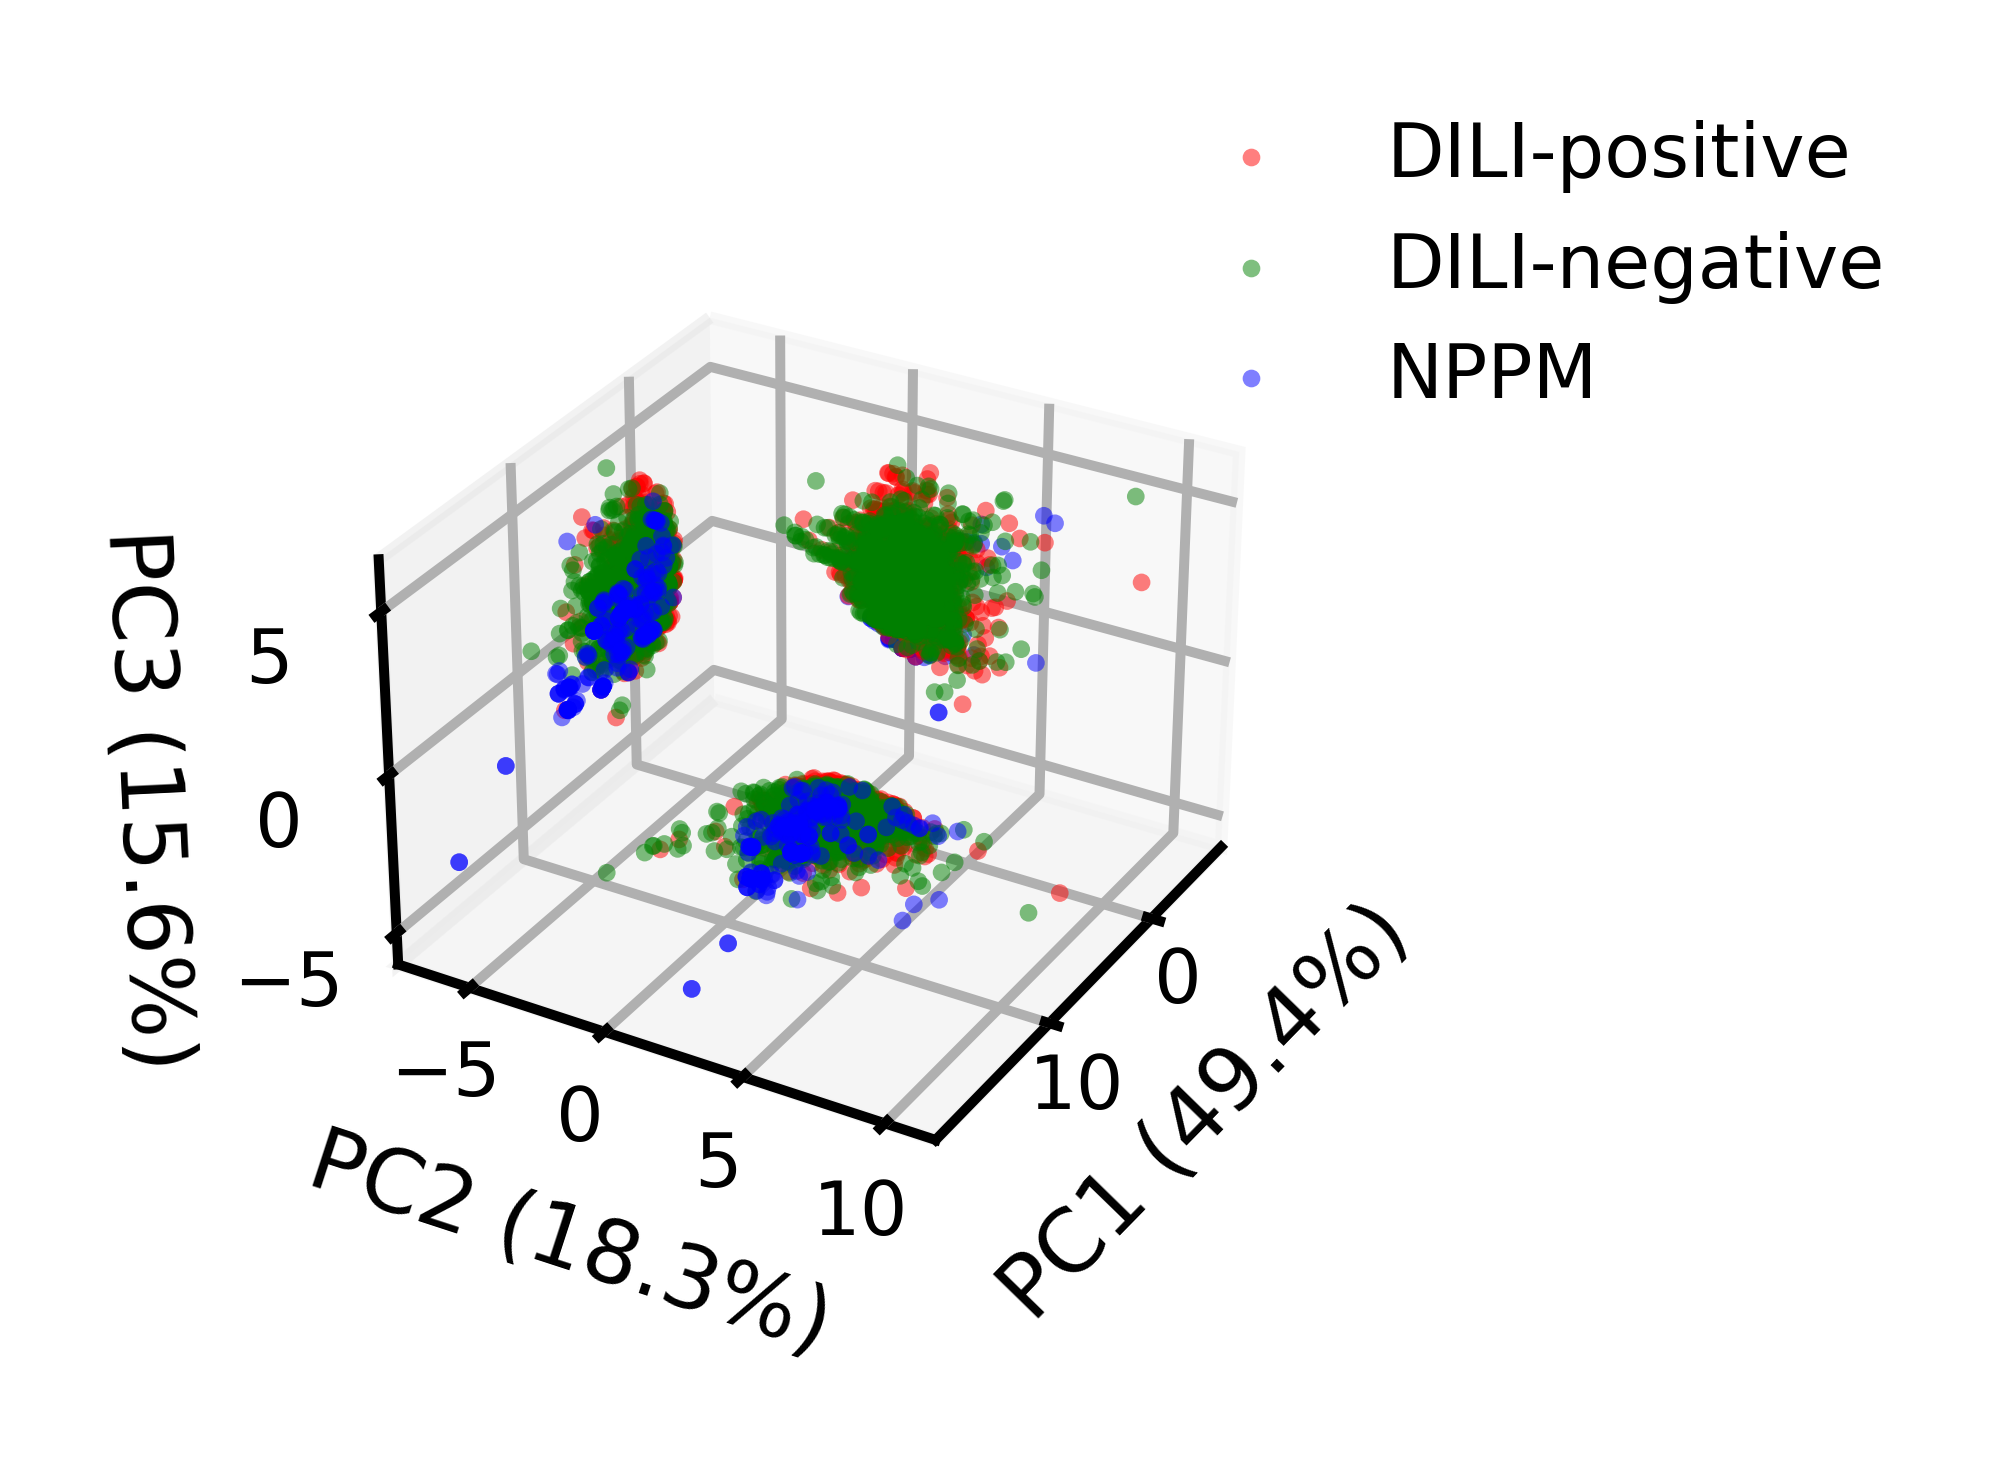

In [8]:
plot = MLPlot()
plot.plot_pca_for3(pos_features, neg_features, pm_features, scale='StandardScaler', component=3, figsize=None, elev=30, azim=30, project=True,
                      alpha=0.5, save_path='results/figure1B.png',
                      label1='DILI-positive', label2='DILI-negative', label3='NPPM',
                      c1='red', c2='green', c3='blue',
                      zorder1=1, zorder2=2, zorder3=3,
                      hide=0)

# Diparametric optimization

## ECFPs

In [13]:
df = pd.read_excel('data/reference_database.xlsx')
df.head()
md = MolecularData()
md.load_data(df=df, smiles_col='SMILES', mode='train', mw_max=5000, label_col='Label')

Number of data set: 2384


In [ ]:
# Param: radius
fp_params = {
    'radius': range(1, 7),
    'nBits': [2048]
}
param_list = ParameterGrid(fp_params)

candidates = {
    'SVC_rbf':
    {
        'kernel': ['rbf'],
        'C': np.linspace(0.1, 2.8, 10),
        'gamma': np.linspace(0.0004, 0.0031, 10)
    },
}
    
tuning_list = []
for param in param_list:
    md.feature_from_smiles({'morgan':param}, rdk_descriptor=False, mode='train')
    md.feature_by_variance(var_thresh=0, mode='train')
    md.feature_by_correlation(high_corr=0.95, labeltype='classification', mode='train')
    md.feature_standardize('StandardScaler')

    md.feature_by_percentile(50, feature_selection.f_classif)
    md.data_sampling(stratify='stratify', test_size=0.2, rand=1)

    cm = ClassificationModel(data=md)
    cm.set_candidates(candidates=candidates)
    cm.model_tuning(scoring=['accuracy'])
    best_df = cm.best_model_select(rank='accuracy')
    best_df = cm.best_model_evaluate(evaluate_metrics=['accuracy_score'])
    best_df['feature_param'] = str(param)
    tuning_list.append(best_df)

In [15]:
df_concat = pd.concat(tuning_list)
save_path = 'results/SVM_ecfp'
df_concat.to_excel('{}.xlsx'.format(save_path))

## RDK fingerprints

In [ ]:
# Param: minPath, maxPath
fp_params = {
    'minPath': range(1, 11),
    'maxPath': range(1, 11),
}
param_list = ParameterGrid(fp_params)

tuning_list = []
for param in param_list:
    if param['minPath'] > param['maxPath']:
        continue
        
    md.feature_from_smiles({'RDK':param}, rdk_descriptor=False, mode='train')
    md.feature_by_variance(var_thresh=0, mode='train')
    md.feature_by_correlation(high_corr=0.95, labeltype='classification', mode='train')
    md.feature_standardize('StandardScaler')

    md.feature_by_percentile(50, feature_selection.f_classif)
    md.data_sampling(stratify='stratify', test_size=0.2, rand=1)

    cm = ClassificationModel(data=md)
    cm.set_candidates(candidates=candidates)
    cm.model_tuning(scoring=['accuracy'])
    best_df = cm.best_model_select(rank='accuracy')
    best_df = cm.best_model_evaluate(evaluate_metrics=['accuracy_score'])
    best_df['feature_param'] = str(param)
    tuning_list.append(best_df)

In [17]:
df_concat = pd.concat(tuning_list)
save_path = 'results/SVM_rdk'
df_concat.to_excel('{}.xlsx'.format(save_path))

## Atom pair fingerprints

In [ ]:
# Param: minLength, maxLength
fp_params = {
    'minLength': range(1, 20, 2),
    'maxLength': range(1, 20, 2),
}
param_list = ParameterGrid(fp_params)

tuning_list = []
for param in param_list:
    if param['minLength'] > param['maxLength']:
        continue
        
    md.feature_from_smiles({'pairs':param}, rdk_descriptor=False, mode='train')
    md.feature_by_variance(var_thresh=0, mode='train')
    md.feature_by_correlation(high_corr=0.95, labeltype='classification', mode='train')
    md.feature_standardize('StandardScaler')

    md.feature_by_percentile(50, feature_selection.f_classif)
    md.data_sampling(stratify='stratify', test_size=0.2, rand=1)

    cm = ClassificationModel(data=md)
    cm.set_candidates(candidates=candidates)
    cm.model_tuning(scoring=['accuracy'])
    best_df = cm.best_model_select(rank='accuracy')
    best_df = cm.best_model_evaluate(evaluate_metrics=['accuracy_score'])
    best_df['feature_param'] = str(param)
    tuning_list.append(best_df)

In [19]:
df_concat = pd.concat(tuning_list)
save_path = 'results/SVM_pair'
df_concat.to_excel('{}.xlsx'.format(save_path))

# Results analysis

## ECFPs

In [44]:
path1 = 'results/SVM_ecfp'
path2 = 'results/SVM_rdk'
path3 = 'results/SVM_pair'

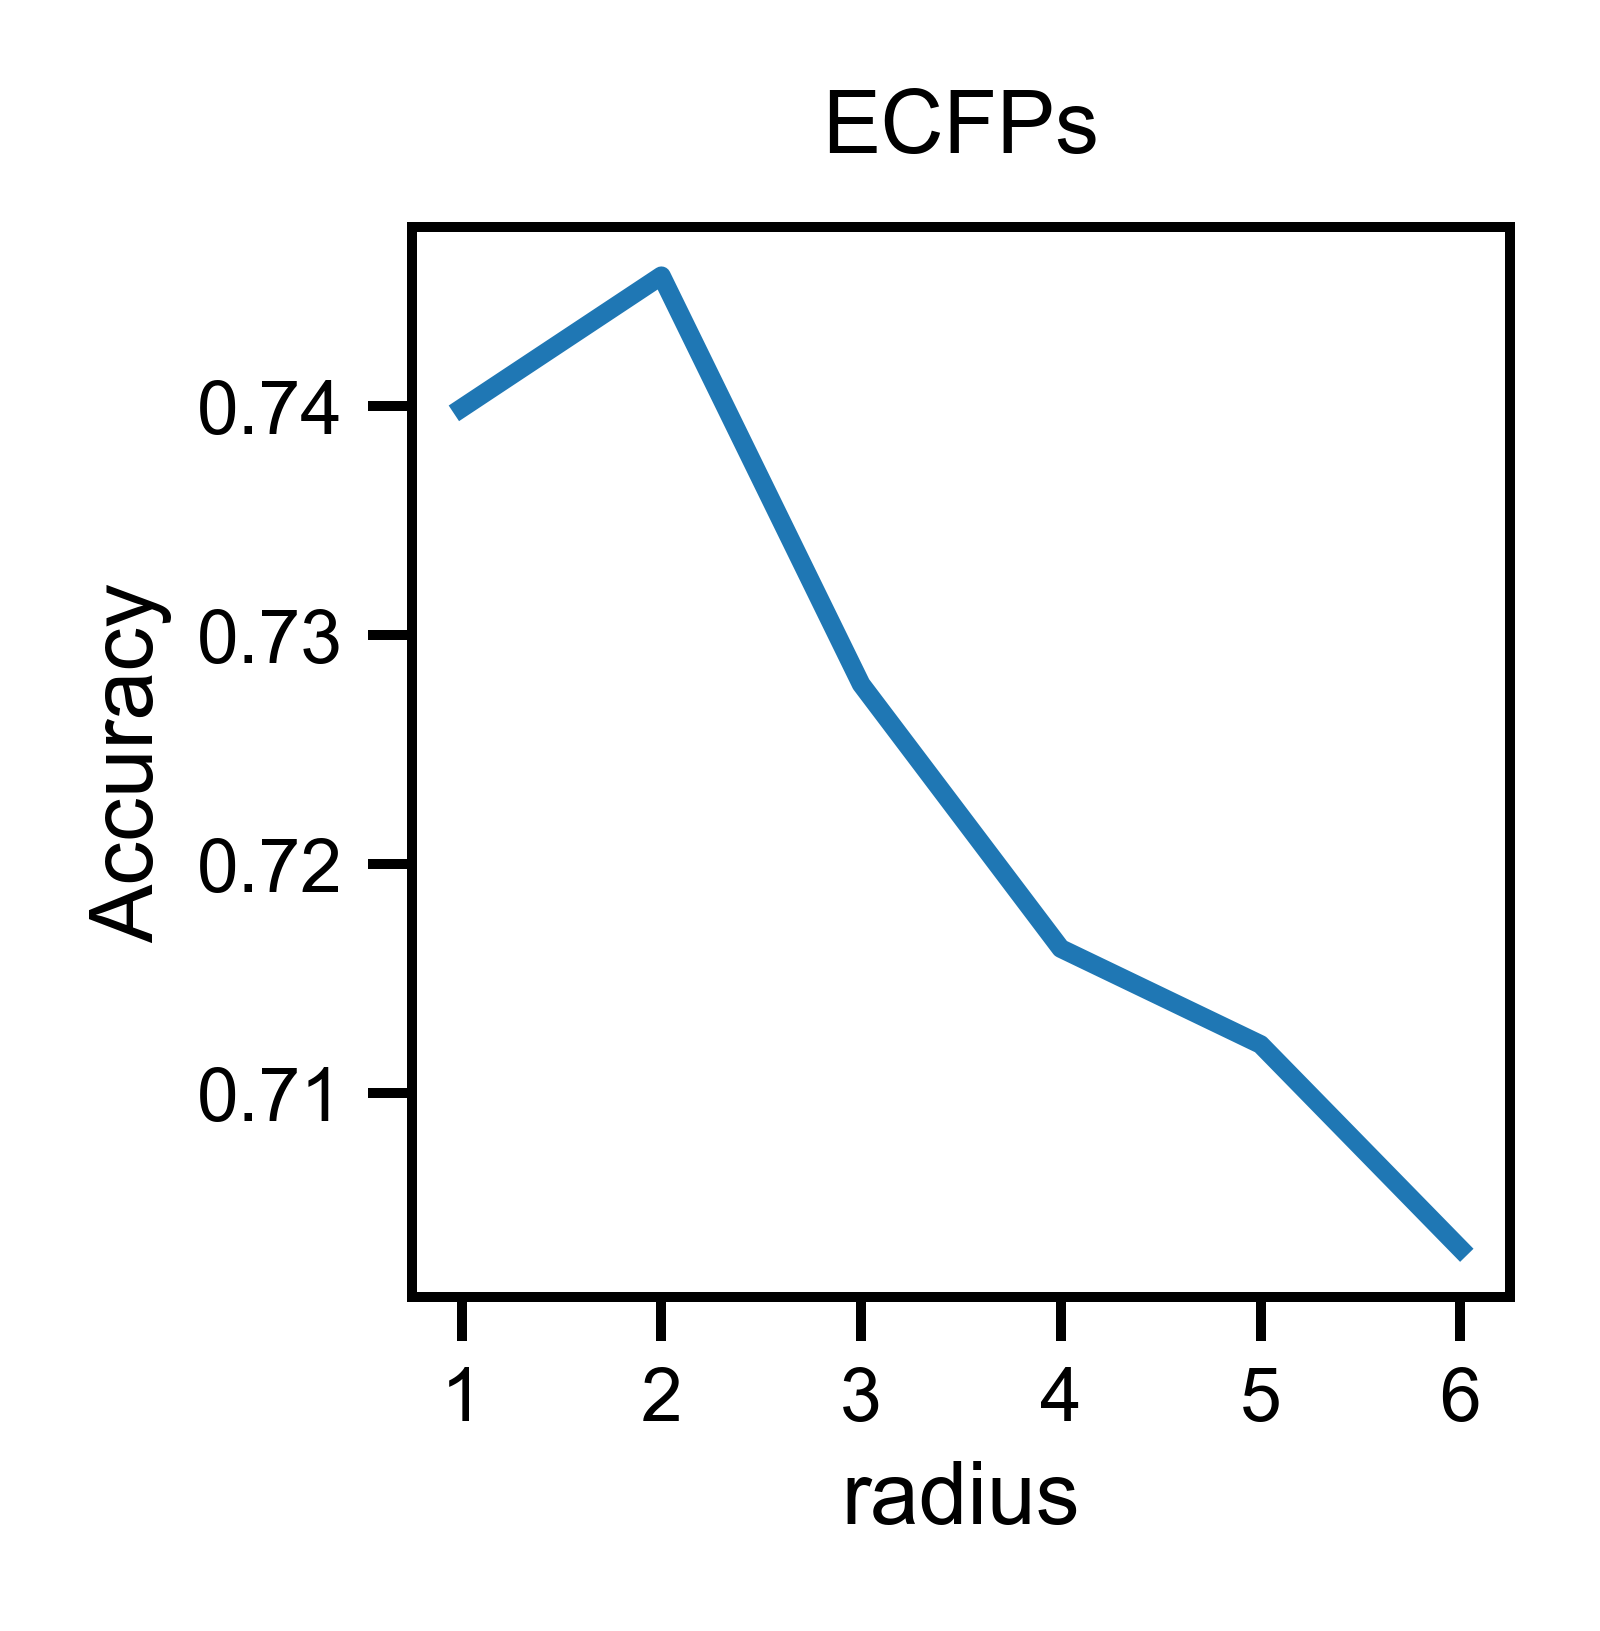

In [45]:
df_concat = pd.read_excel(f'{path1}.xlsx')

feature_col = 'feature_param'
param1 = 'radius'
for i, row in df_concat.iterrows():
    feature_param = eval(row[feature_col])
    if param1 in row['feature_param']:
        df_concat.loc[i, param1] = feature_param[param1]

save_path = None

# global value
xmajorLocator = 1
ymajorLocator = 0.01
param1_name = 'radius'
param2_name = 'Accuracy'
res_name = 'mean_test_accuracy'
fig_title = 'ECFPs'

# draw
fig = plt.figure(1, figsize=(4 / 2.54, 4 / 2.54), dpi=900)
plt.plot(df_concat[param1], df_concat[res_name]) #**line_params)

# set the x ticks format
ax = plt.gca()
xmajorLocator = MultipleLocator(xmajorLocator)
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_major_formatter(FormatStrFormatter('%i'))

# # set the y ticks format
ymajorLocator = MultipleLocator(ymajorLocator)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# set title
plt.title(fig_title, fontsize=7)

# set the ticks properties
tick_size = 6
ax.tick_params(axis='x', labelsize=tick_size, pad=2)
ax.tick_params(axis='y', labelsize=tick_size, pad=2)

# set the label properties
label_size = 7
ax.set_xlabel(param1_name, labelpad=2, fontsize=label_size)
ax.set_ylabel(param2_name, labelpad=2, fontsize=label_size)

# plt.tight_layout()
plt.savefig('results/figure2A.png', bbox_inches='tight', transparent=True)
plt.show()

## RDK fingerprints

In [48]:
# variables
df_concat = pd.read_excel('{}.xlsx'.format(path2))
param1 = 'minPath'
param2 = 'maxPath'
results = 'mean_test_accuracy'
feature_col = 'feature_param'
param1_name = 'minPath'
param2_name = 'maxPath'
res_name = 'acc'
title = 'SVM tuning results'

matrix_max_round = np.ceil(df_concat[results].max()*100) / 100
matrix_min_round = np.floor(df_concat[results].min()*100) / 100
fix_ = [matrix_min_round, matrix_max_round]

In [ ]:
_path = '{}_{}.png'.format(path2, results)
plot.plot_3D_tuning_results_for_feature(df_concat, param1, param2, results, feature_col, param1_name, param2_name, res_name, title, None, elev=25, azim=165, fix_min_max=fix_, ymajorLocator=4, xmajorLocator=4, point=None)

In [50]:
# generate the tuning matrix
matrix = defaultdict(dict)
for i, row in df_concat.iterrows():
    matrix[row[param1]][row[param2]] = row[results] 
matrix = dict(matrix)

# sort index
df = pd.DataFrame(matrix).sort_index(axis=0).sort_index(axis=1)

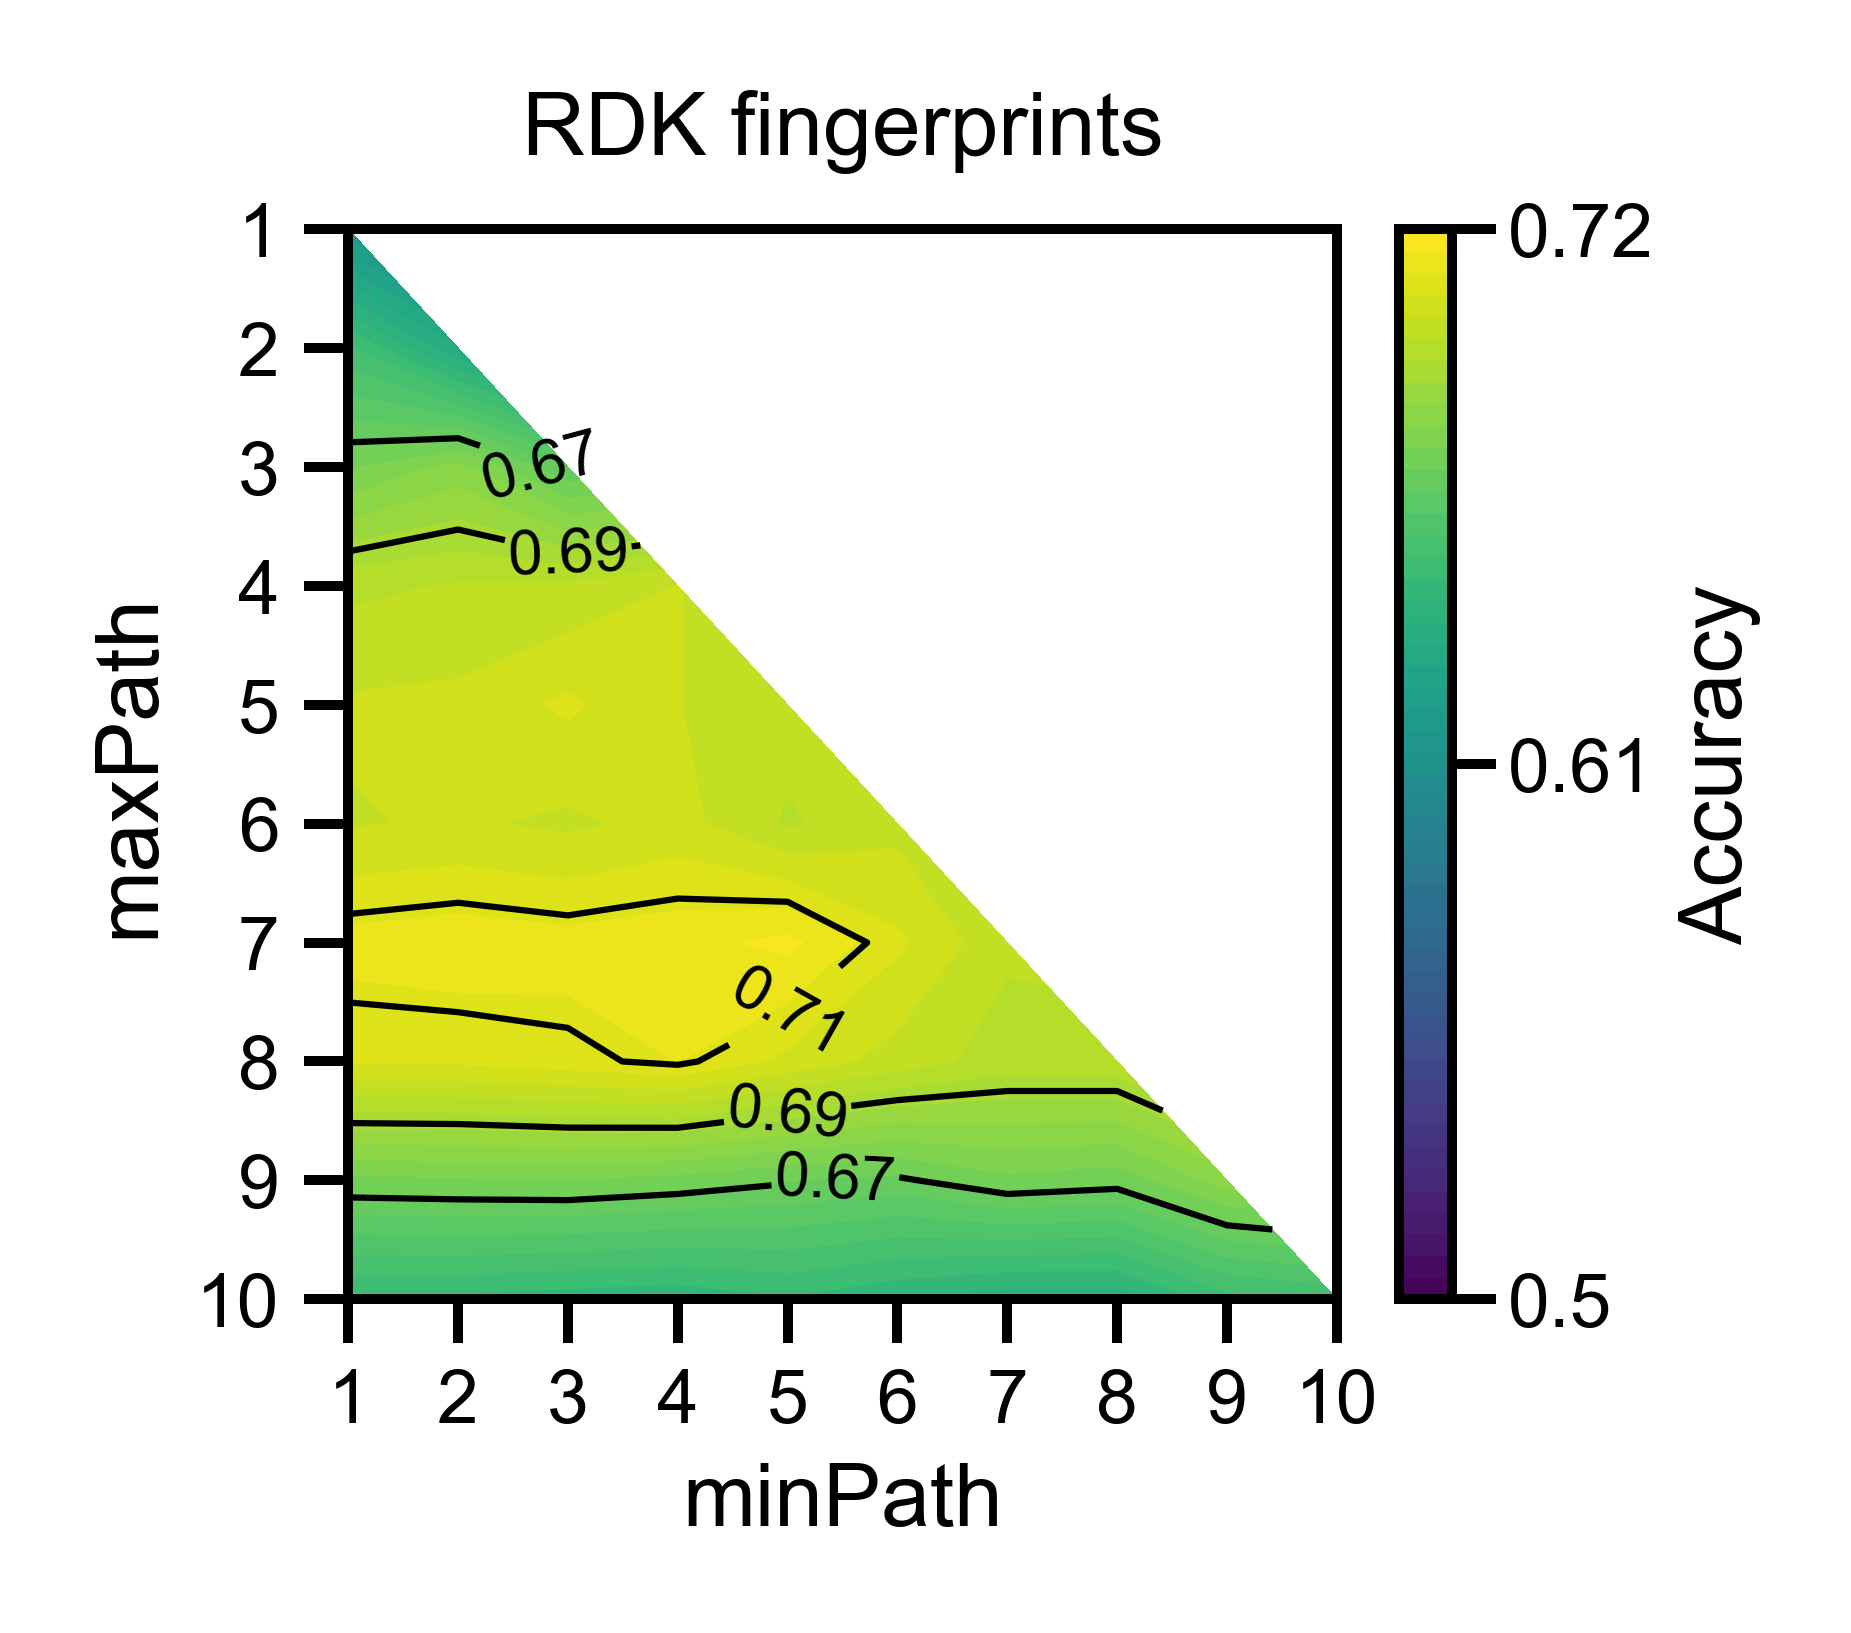

In [51]:
plot.plot_2D_fingerprints_param(df, min_value=0.5, max_value=0.72, save_path='results/figure2B.png',
                           fig_title='RDK fingerprints', cbar_label='Accuracy', line=[0.67, 0.69, 0.71],
                           param1_name=param1_name, param2_name=param2_name)

## atom pair fingerprints

In [52]:
# variables
df_concat = pd.read_excel('{}.xlsx'.format(path3))
param1 = 'minLength'
param2 = 'maxLength'
results = 'mean_test_accuracy'
feature_col = 'feature_param'
param1_name = 'minLength'
param2_name = 'maxLength'
res_name = 'acc'
title = 'SVM tuning results'

matrix_max_round = np.ceil(df_concat[results].max()*100) / 100
matrix_min_round = np.floor(df_concat[results].min()*100) / 100
fix_ = [matrix_min_round, matrix_max_round]

In [ ]:
_path = '{}_{}.png'.format(path2, results)
plot.plot_3D_tuning_results_for_feature(df_concat, param1, param2, results, feature_col, param1_name, param2_name, res_name, title, None, elev=25, azim=165, fix_min_max=fix_, ymajorLocator=4, xmajorLocator=4, point=None)

In [54]:
# generate the tuning matrix
matrix = defaultdict(dict)
for i, row in df_concat.iterrows():
    matrix[row[param1]][row[param2]] = row[results] 
matrix = dict(matrix)

# sort index
df = pd.DataFrame(matrix).sort_index(axis=0).sort_index(axis=1)

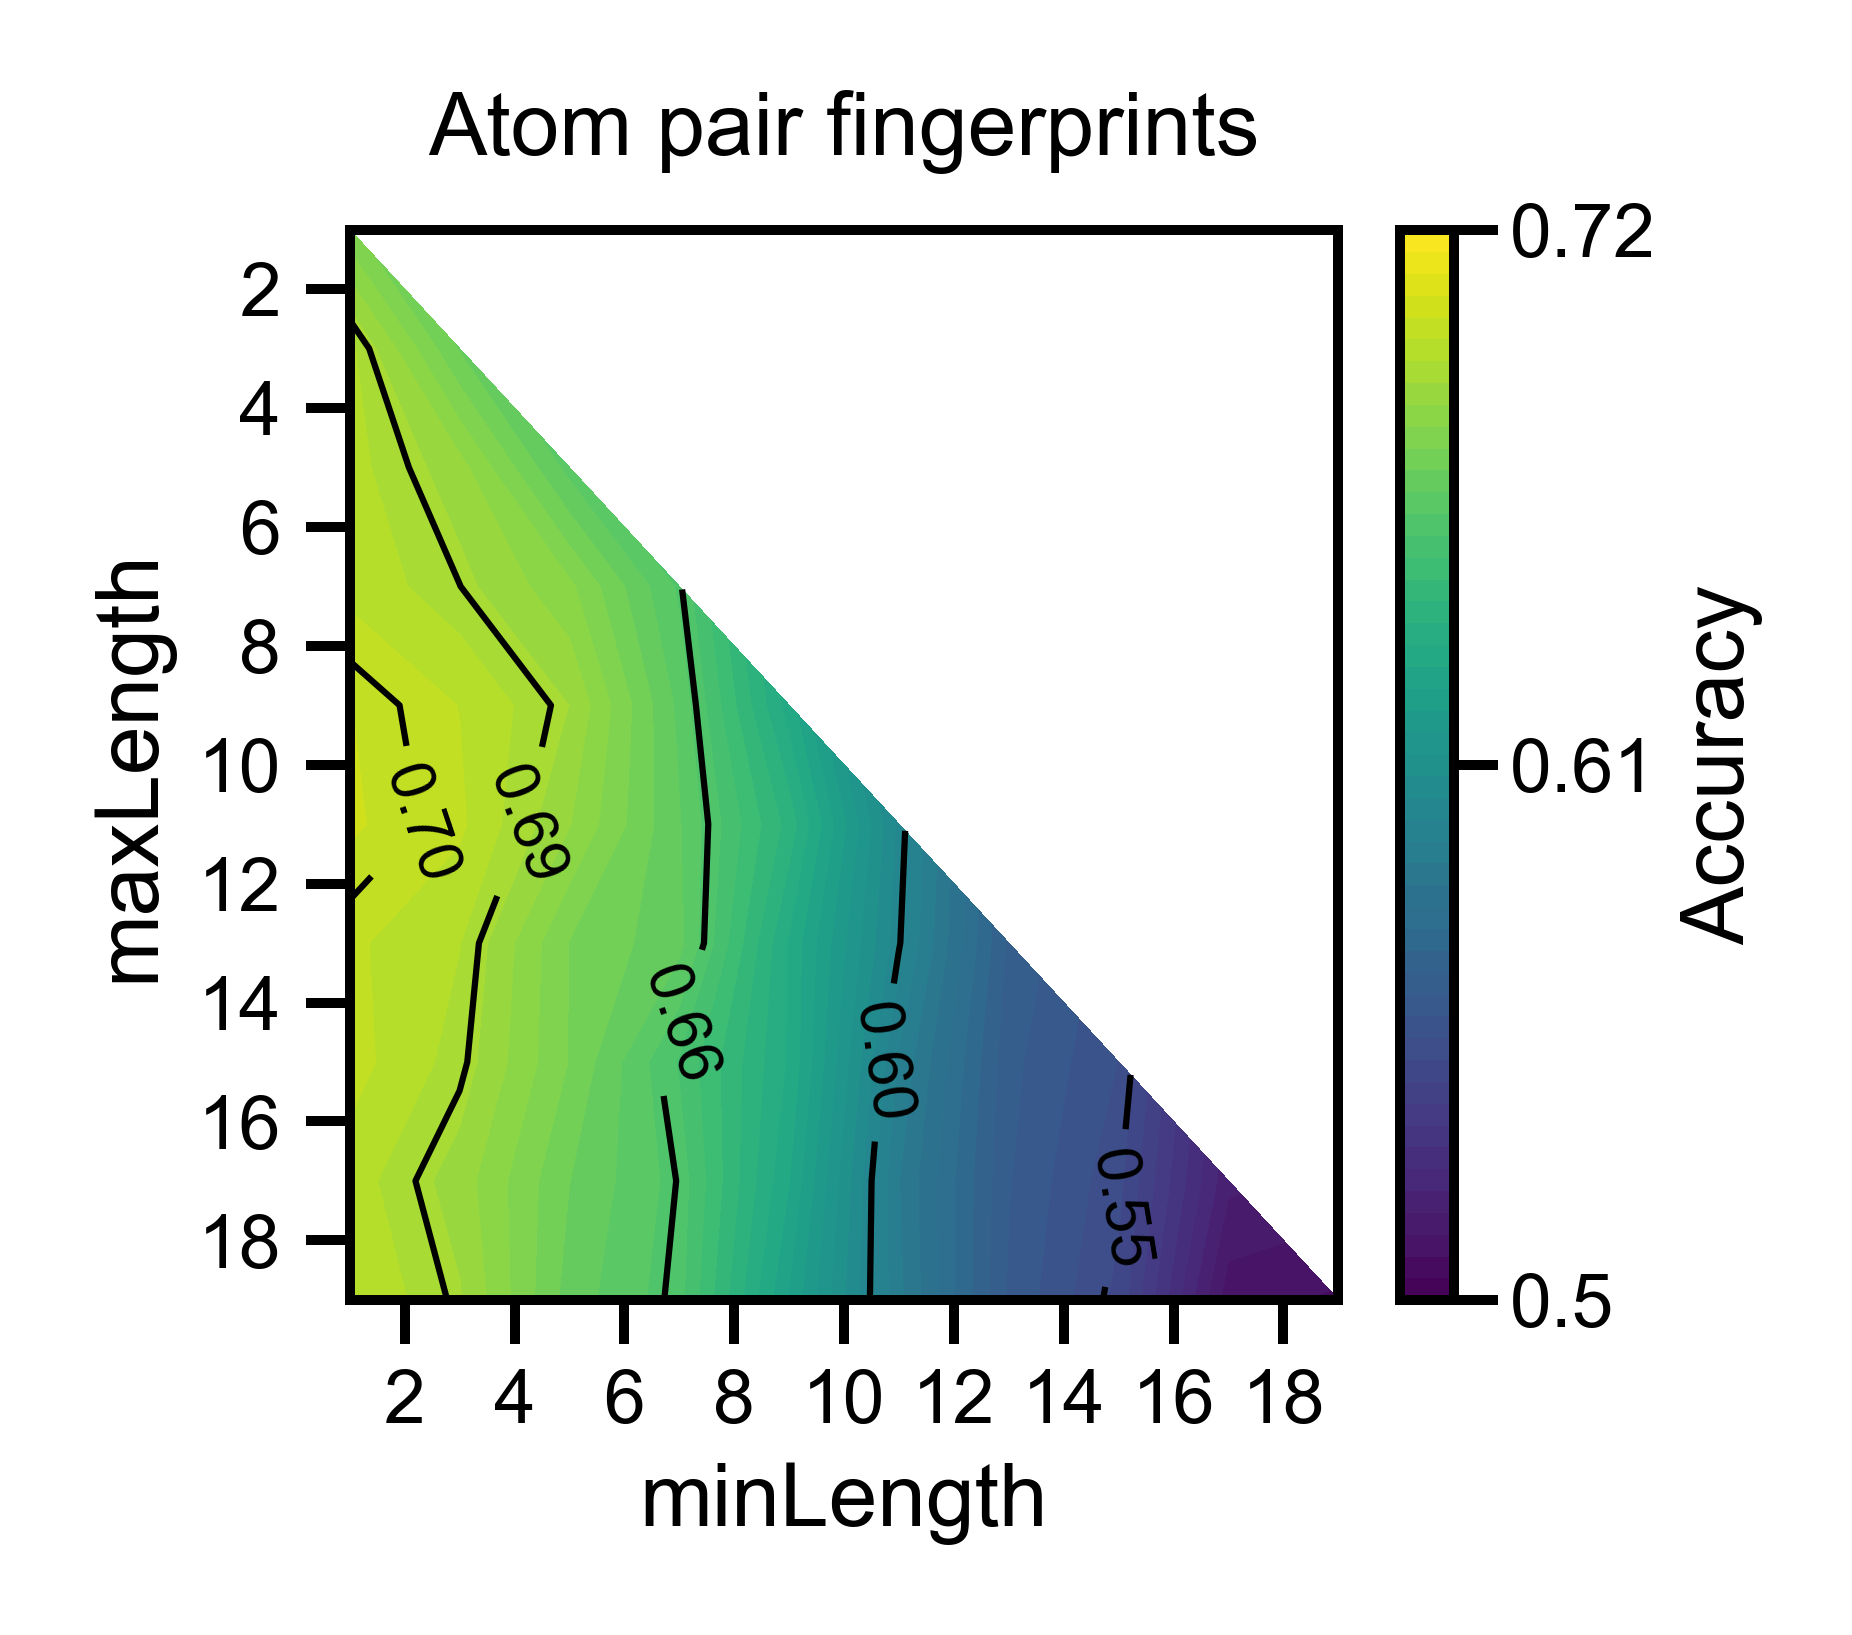

In [55]:
plot.plot_2D_fingerprints_param(df, min_value=0.5, max_value=0.72, save_path='results/figure2C.png',
                           fig_title='Atom pair fingerprints', cbar_label='Accuracy', line=[0.55, 0.60, 0.66, 0.69, 0.70],
                           param1_name=param1_name, param2_name=param2_name, xmajorLocator=2, ymajorLocator=2)

# Predict the DILI-potential of NPPM

## Training and predict

In [ ]:
df = pd.read_excel('data/reference_database.xlsx')
md = MolecularData()
md.load_data(df=df, smiles_col='SMILES', mode='train', mw_max=5000, label_col='Label')

rdk_fps = [
    {'rdk_fp':{'morgan':
        {
            'radius': 2,
            'nBits': 2048,
            'useFeatures': False
        },},
    'rdk_descriptor':False},
]

tuning_list1 = []
for rdk_fp in rdk_fps:
    md.feature_from_smiles(**rdk_fp, mode='train')
    md.feature_by_variance(var_thresh=0, mode='train')
    md.feature_by_correlation(high_corr=0.95, labeltype='classification', mode='train')
    md.feature_standardize('StandardScaler')
    md.feature_by_percentile(35, feature_selection.f_classif)
    
    candidates={
                        'SVC_rbf':
                        {
                                'kernel': ['rbf'],
                                'C': [1.3],
                                'gamma': [0.0007],
                            },
            }
    md.data_sampling(stratify='stratify', test_size=0.2, rand=1)

    cm = ClassificationModel(data=md)
    cm.set_candidates(candidates=candidates)
    cm.model_tuning(scoring=['accuracy'])
    best_df = cm.best_model_select(rank='accuracy')
    best_df = cm.best_model_evaluate(evaluate_metrics=['accuracy_score'])
    best_df['feature_param'] = str(rdk_fp)
    tuning_list1.append(best_df)

In [ ]:
pm_df = pd.read_excel('data/Polygonum_database.xlsx')
pm_df.head()
md.load_data(df=pm_df, smiles_col='SMILES', mode='predict', mw_max=5000)
md.features_for_prediction()
md.engineer_for_prediction()
cm.load_predict_data(data=md)
out = cm.best_model_predict()

## Compounds predicted as DILI-positive

In [64]:
pos = out[out['SVC_rbf_0'] == 'Pos']
pos[['Name', 'SVC_rbf_0']]

,Name,SVC_rbf_0
21,Emodin,Pos
23,Chrysophanol,Pos
24,Physcion,Pos
25,Rhein,Pos
26,"1,6-dimethyl ether-emodin",Pos
27,Emodin-8-methyl ether,Pos
30,Lunatin,Pos
32,"Emodin-6,8-dimethylether",Pos
33,2-acetyl-emodin,Pos
41,2-Methoxy-6-acethyl-7-methyliuglone,Pos


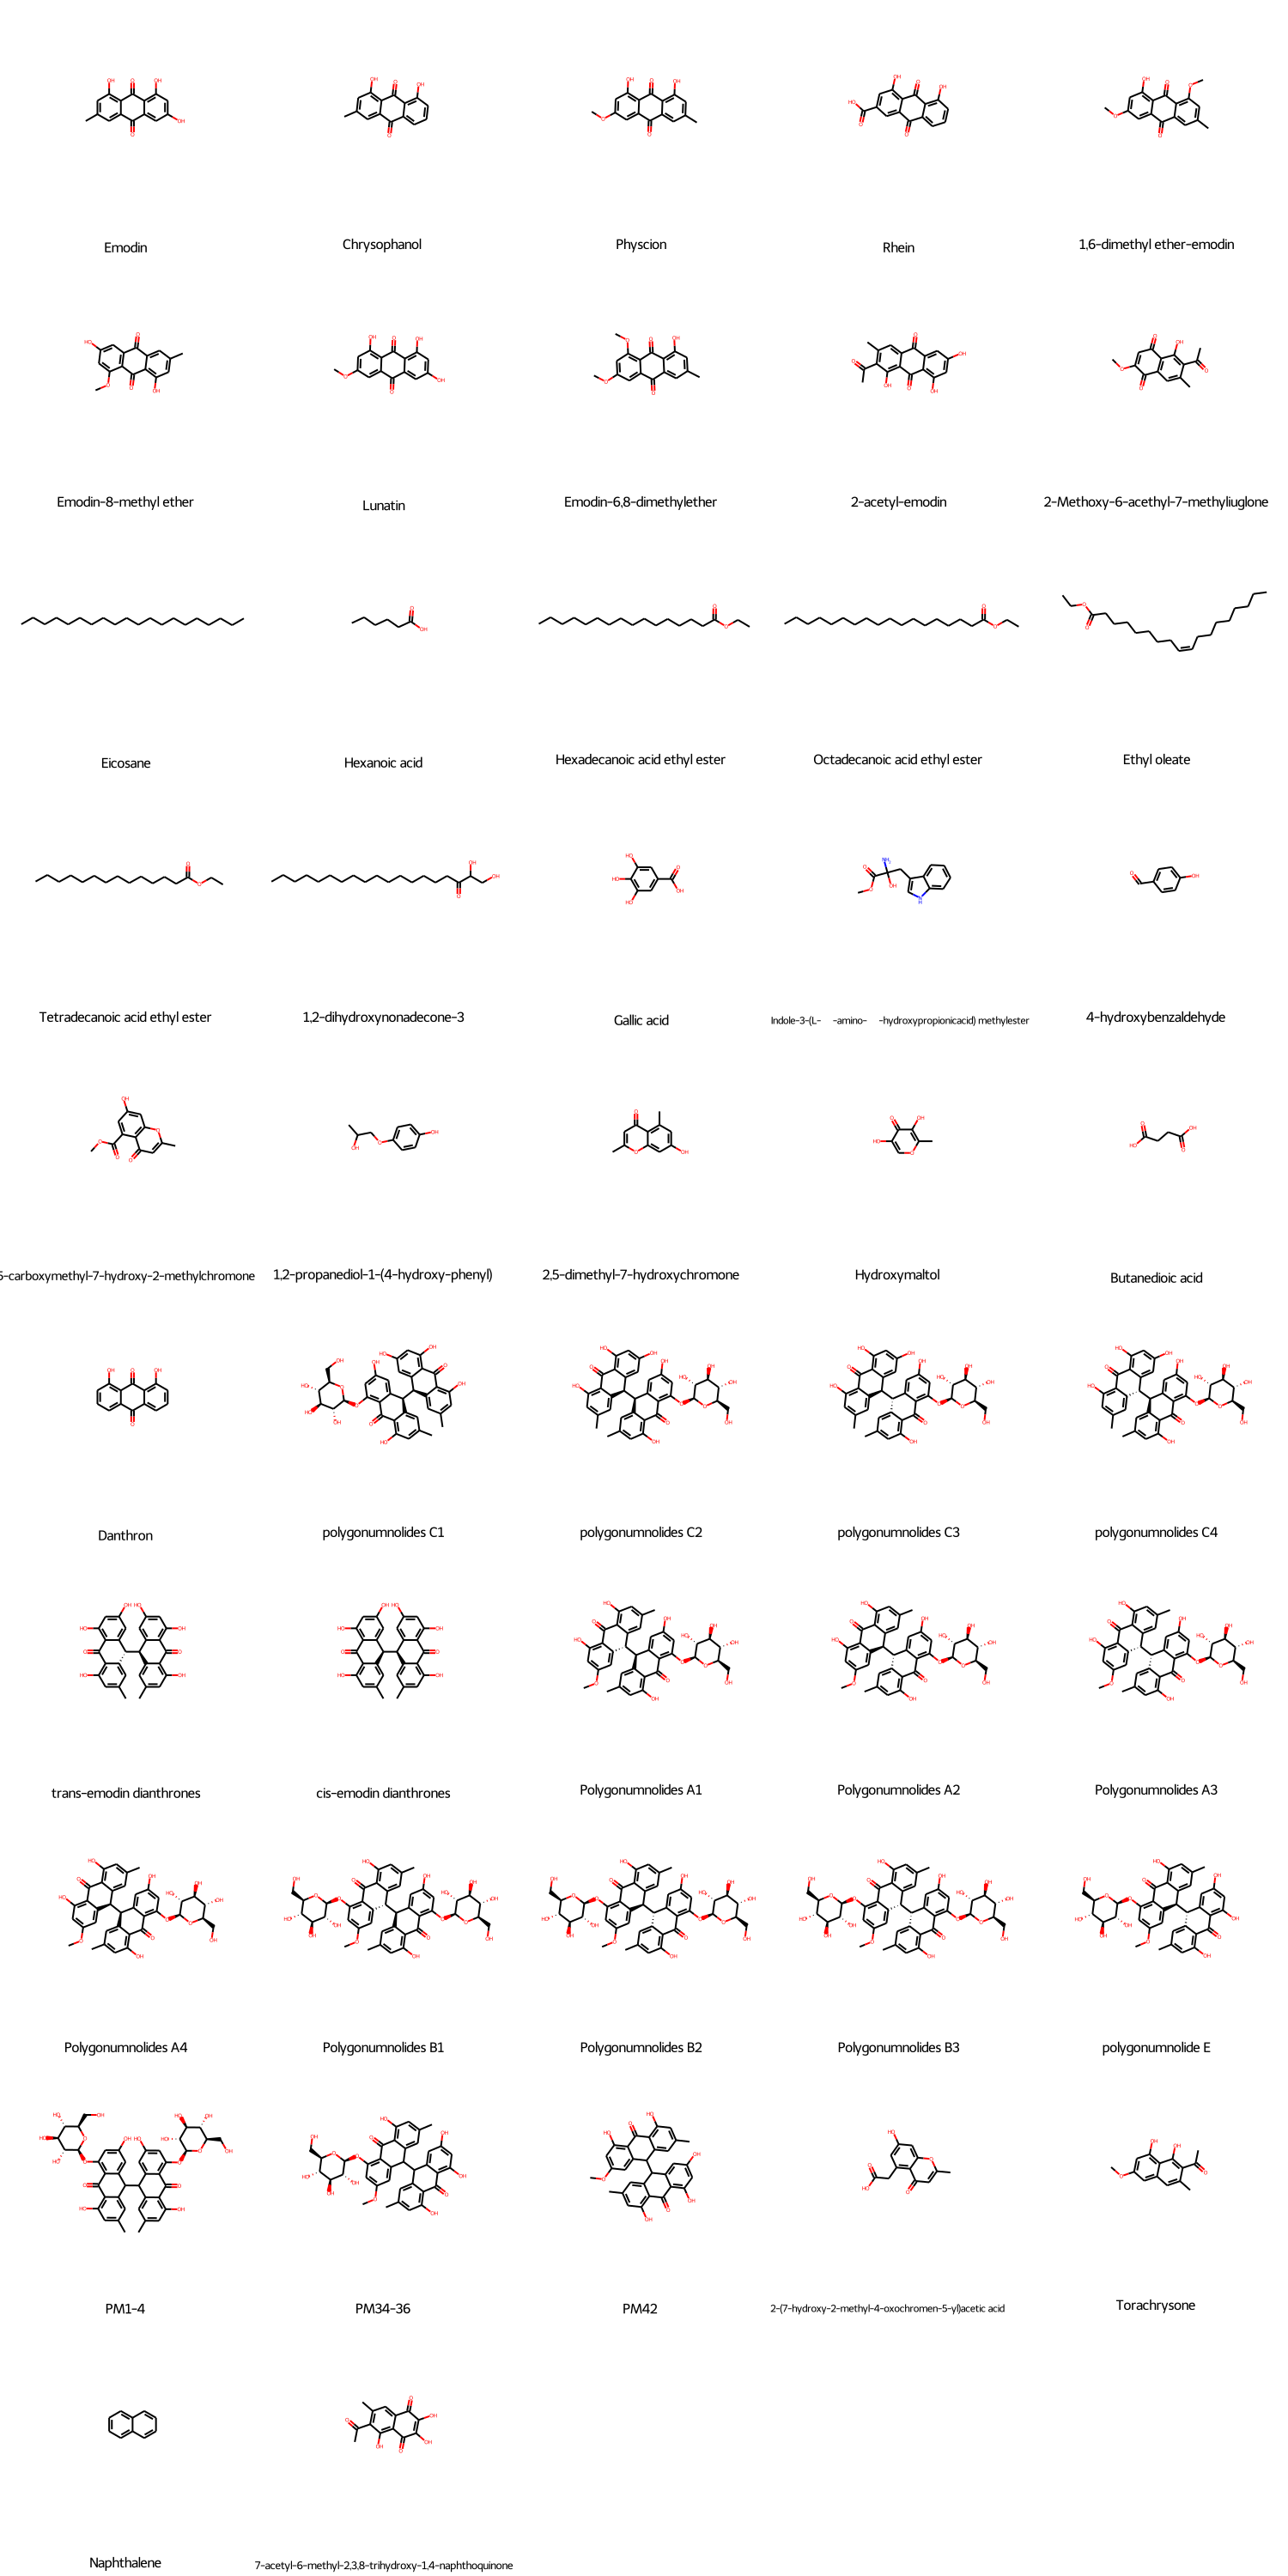

In [65]:
pos_mol = list(map(Chem.MolFromSmiles, pos.SMILES.to_list()))
Chem.Draw.MolsToGridImage(pos_mol, molsPerRow=5, subImgSize=(300,300), legends=list(pos.Name))